# Processing of Sentinel-1 InSAR pairs

In [ ]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib.pyplot as plt

import geopandas as gpd
from eodag import EODataAccessGateway
import rioxarray as riox

# credentials need to be stored in the following file (see EODAG docs)
confpath = "/data/eodag_config.yml"
dag = EODataAccessGateway(user_conf_file_path=confpath)
# make sure cop_dataspace will be used 
dag.set_preferred_provider("cop_dataspace")
logging.basicConfig(level=logging.INFO)

# Set up parameters and output dir

## Important
- The products must be **unzipped** either manually or by using `extract=True` in the download call. 
- In the following products, only IW1 and IW2 are relevant as IW3 contains only water pixels.

In [ ]:
# change these to your directories
data_dir = "/data/S1"
out_dir = f"/data/res/Morocco-earthquake-2023-iw1"

# for this demo, we will use these products
ids = [
 "S1A_IW_SLC__1SDV_20230904T063730_20230904T063757_050174_0609E3_DAA1", 
 "S1A_IW_SLC__1SDV_20230916T063730_20230916T063757_050349_060FCD_6814"
]
primary_dir = f"{data_dir}/{ids[0]}.SAFE"
secondary_dir = f"{data_dir}/{ids[1]}.SAFE"
iw = 1 # subswath
pol = "vv" # polarization ("vv"or "vh")
min_burst = 3
max_burst = 6 # Set to None to process all (warning: memory hungry)

# Download S-1 products

In [ ]:
# load a geometry
file_aoi = "../data/Morocco_AOI.geojson"
shp = gpd.read_file(file_aoi).geometry[0]
search_criteria = {
    "productType": "S1_SAR_SLC",
    "start": "2023-09-03",
    "end": "2023-09-17",
    "geom": shp
}

results, _ = dag.search(**search_criteria)
to_dl = [it for it in results if it.properties["id"] in ids]
print(f"{len(to_dl)} products to download")
dag.download_all(to_dl, outputs_prefix=data_dir, extract=False)

# Pre-process InSAR pair

In [ ]:
from eo_tools.S1.process import preprocess_insar_iw

# TODO: use downloaded products
preprocess_insar_iw(
    primary_dir,
    secondary_dir,
    out_dir,
    iw=iw,
    pol=pol,
    min_burst=min_burst,
    max_burst=max_burst,
    dem_upsampling=1.8,
    apply_fast_esd=True,
    # dem_force_download=True
)

# Apply geocoding using lookup tables

In [ ]:
from eo_tools.S1.process import slc2geo, coherence, amplitude
file_prm = f"{out_dir}/primary.tif"
file_sec = f"{out_dir}/secondary.tif"
file_amp = f"{out_dir}/amp.tif"
file_coh = f"{out_dir}/coh.tif"
file_phi_geo = f"{out_dir}/phi_geo.tif"
file_amp_geo = f"{out_dir}/amp_geo.tif"
file_coh_geo = f"{out_dir}/coh_geo.tif"
file_lut = f"{out_dir}/lut.tif"
# computing amplitude and complex coherence  in the radar geometry
coherence(file_prm, file_sec, file_coh, box_size=[3,10], magnitude=False)
amplitude(file_prm, file_amp)

# combined multilooking and geocoding
# interferometric coherence
slc2geo(file_coh, file_lut, file_coh_geo, 1, 4, "bicubic", write_phase=False, magnitude_only=True)

# interferometric phase
slc2geo(file_coh, file_lut, file_phi_geo, 1, 4, "bicubic", write_phase=True)

# amplitude of the primary image
slc2geo(file_amp, file_lut, file_amp_geo, 2, 8, "bicubic", False, True)

# Visualize

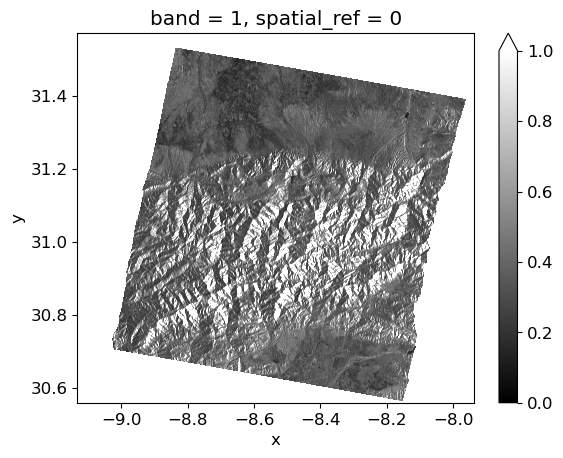

In [10]:
arr_amp = riox.open_rasterio(file_amp_geo, masked=True)[0]
arr_amp.plot.imshow(vmin=0,vmax=1, cmap="gray", interpolation="bilinear")

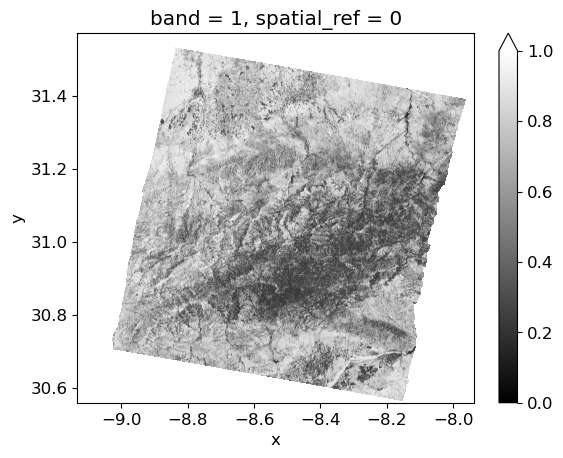

In [9]:
arr_coh = riox.open_rasterio(file_coh_geo, masked=True)[0]
arr_coh.plot.imshow(vmin=0,vmax=1, cmap="gray", interpolation="bilinear")

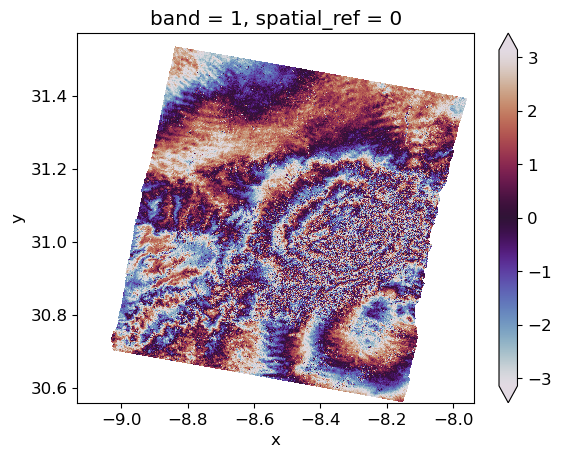

In [11]:
arr_phi = riox.open_rasterio(file_phi_geo, masked=True)[0]
arr_phi.plot.imshow(vmin=-3.14, vmax=3.14, cmap="twilight")